In [1]:
import os,sys
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader
import transforms as T
from engine import train_one_epoch
from utils import * 
from datasets import PennFudanDataset

c:\Users\yunja\.conda\envs\ailab_sc\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\yunja\.conda\envs\ailab_sc\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may

In [2]:
data_path = 'C:\\Users\\yunja\\Desktop\\summer_camp_codes\\data\\PennFudanPed\\PennFudanPed'
save_path = 'C:\\Users\\yunja\\Desktop\\summer_camp_codes\\parameter'
num_epoch = 10

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [4]:
trainset = PennFudanDataset(data_path, get_transform(train=True))
testset = PennFudanDataset(data_path, get_transform(train=False))

indices = torch.randperm(len(trainset)).tolist()
dataset = torch.utils.data.Subset(trainset, indices[:-1])
dataset_test = torch.utils.data.Subset(testset, indices[-1:])

trainLoader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
testLoader = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [5]:
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features

backbone.out_channels = 1280

anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0005)

In [6]:
for epoch in range(num_epoch):
    train_one_epoch(model, optimizer, trainLoader, device, epoch, print_freq=10)
torch.save(model.state_dict(), os.path.join(save_path, 'detector.pth'))

Epoch: [0]  [  0/169]  eta: 0:08:54  lr: 0.000069  loss: 1.4670 (1.4670)  loss_classifier: 0.7173 (0.7173)  loss_box_reg: 0.0416 (0.0416)  loss_objectness: 0.6877 (0.6877)  loss_rpn_box_reg: 0.0204 (0.0204)  time: 3.1602  data: 0.0211  max mem: 1941
Epoch: [0]  [ 10/169]  eta: 0:01:21  lr: 0.000664  loss: 1.5416 (1.5451)  loss_classifier: 0.7118 (0.7092)  loss_box_reg: 0.1054 (0.1133)  loss_objectness: 0.6877 (0.6872)  loss_rpn_box_reg: 0.0291 (0.0354)  time: 0.5121  data: 0.0186  max mem: 2458
Epoch: [0]  [ 20/169]  eta: 0:00:56  lr: 0.001259  loss: 1.4830 (1.4804)  loss_classifier: 0.6779 (0.6751)  loss_box_reg: 0.0753 (0.0921)  loss_objectness: 0.6829 (0.6850)  loss_rpn_box_reg: 0.0148 (0.0282)  time: 0.2407  data: 0.0158  max mem: 2488
Epoch: [0]  [ 30/169]  eta: 0:00:45  lr: 0.001853  loss: 1.3427 (1.4242)  loss_classifier: 0.5850 (0.6311)  loss_box_reg: 0.0634 (0.0882)  loss_objectness: 0.6720 (0.6774)  loss_rpn_box_reg: 0.0127 (0.0274)  time: 0.2300  data: 0.0142  max mem: 2528


In [24]:
imgs, targets= next(iter(testLoader))
img = imgs[0]
sample = img.permute(1,2,0).cpu().numpy()
target = targets[0]
boxes = target['boxes'].cpu().numpy().astype(int)
print(boxes)

[[ 29 117 166 412]
 [119 148 256 412]
 [215 151 353 415]
 [704 128 838 389]
 [344 161 423 341]]


In [25]:
model.eval()
device = torch.device('cpu')
model = model.to(device)
outputs = model(img.unsqueeze(0))
outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


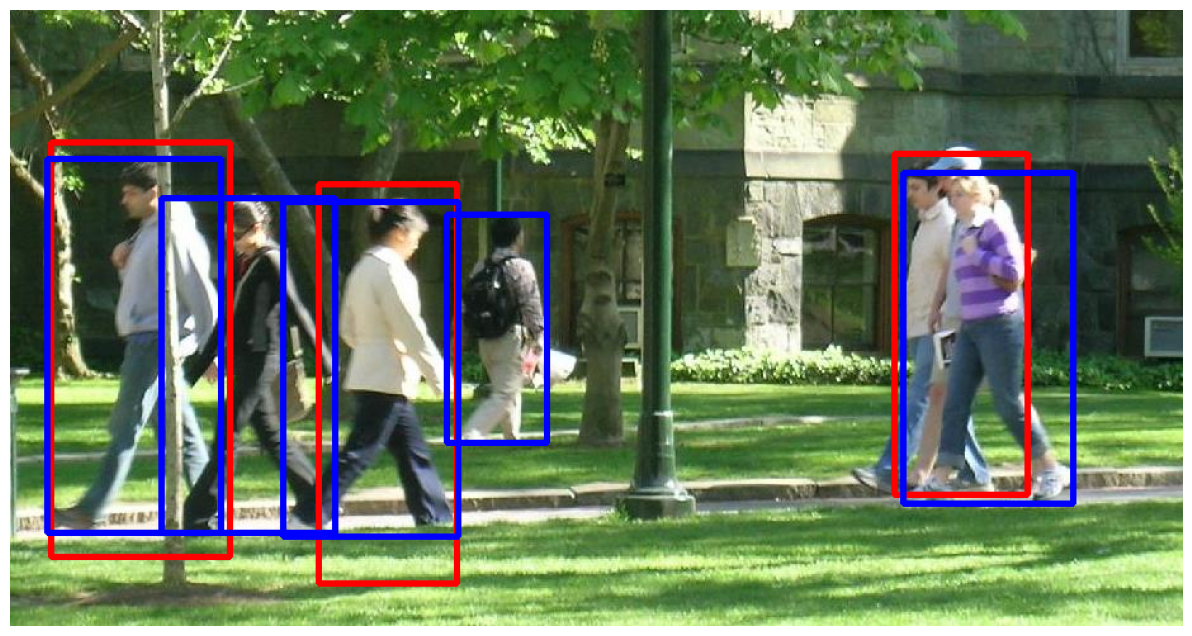

In [29]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline 

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

count = 0
mean_score = torch.mean(outputs[0]['scores'])

for box, score in zip(outputs[0]['boxes'].int(), outputs[0]['scores']):
    if score > 0.75:
        cv2.rectangle(sample,(box[0].item(), box[1].item()),(box[2].item(), box[3].item()),(220, 0, 0), 3)
        count += 1
        
for box in zip(targets[0]['boxes'].int()):
    box = box[0]
    cv2.rectangle(sample,(box[0].item(), box[1].item()),(box[2].item(), box[3].item()),(0, 0, 255), 3)
    count += 1
    
ax.set_axis_off()
ax.imshow(sample)
